# Aprendizaje no supervisado

## 1. Librerias y Datos

In [3]:
import pandas as pd
import numpy as np
import io
import warnings
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
warnings.filterwarnings('ignore')
import seaborn as sb
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.tree import export_text
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
#import graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from matplotlib import pyplot
from sklearn.ensemble import ExtraTreesClassifier
# Useful functions
from src.utils import load_examples, plot_scatter, plot_silhouette

from sklearn.cluster import KMeans

In [17]:
data = pd.read_csv('data.csv')
data['stays_nights']=data.stays_in_weekend_nights+data.stays_in_week_nights
data=data.drop([stays_in_weekend_nights','stays_in_week_nights'],axis=1)
data.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,is_repeated_guest,previous_cancellations,...,meal_FB,meal_HB,meal_SC,meal_Undefined,deposit_type_Non Refund,deposit_type_Refundable,reserverd/assigned,customer_type_Group,customer_type_Transient-Party,stays_nights
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,0.368367,8.280793,2016.156167,27.144700,15.785733,1.863632,0.106705,0.007900,0.032400,0.089067,...,0.006100,0.122200,0.090733,0.009367,0.120433,0.001200,0.872467,0.004733,0.960500,3.440500
std,0.482370,2.027570,0.706490,13.649126,8.800606,0.635565,0.403716,0.105062,0.177063,0.881756,...,0.077865,0.327522,0.287234,0.096329,0.325473,0.034621,0.333575,0.068637,0.194785,2.593791
min,0.000000,0.763433,2015.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7.664083,2016.000000,16.000000,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000
50%,0.000000,8.326678,2016.000000,27.000000,16.000000,2.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,3.000000
75%,1.000000,9.003887,2017.000000,38.000000,23.000000,2.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,4.000000
max,1.000000,17.690502,2017.000000,53.000000,31.000000,55.000000,3.000000,10.000000,1.000000,26.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,69.000000


## 2. K-means

Lo vamos a separar en dos partes:
1. Primero vamos a usar como objetivo la variabla is_canceled, por lo que vamos a intentar clasificar nuestros datos en dos clusters y ver el resultado.

2. Despúes vamos a ver cual es el número más óptimo de clusters utilizando como objetivo la variable stays_nights, para entonces ver si tiene sentido separar esa variable en varias subclases en función del número de clusters 

### Variable Objetivo: is_canceled

Vamos a normalizar los datos y usar dos clusters para intentar clasificar en función de los dos valores de nuestra variable objetivo:

In [3]:
X = data.drop(['is_canceled', 'Unnamed: 0'], axis=1).values
Y = data.is_canceled

In [4]:
from sklearn import preprocessing 

scaler = preprocessing.StandardScaler().fit(X)
Xs = scaler.transform(X)

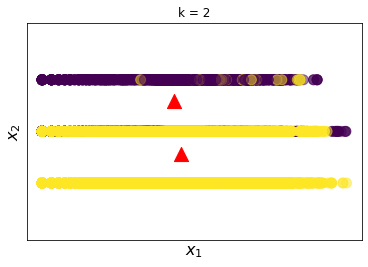

In [10]:
# build the clustering model
k = 2
kmeans = KMeans(n_clusters = k)
kmeans.fit(Xs)

# Centroids 
centroids = kmeans.cluster_centers_

# Labels
cluster_labels = kmeans.labels_

# do the plotting
plot_scatter(Xs,'k = ' + str(k), cluster_labels, centroids)
plt.show()

In [11]:
kmeans.predict(X)

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [12]:
Y

0        0.0
1        1.0
2        0.0
3        0.0
4        1.0
        ... 
29995    0.0
29996    0.0
29997    0.0
29998    1.0
29999    0.0
Name: is_canceled, Length: 30000, dtype: float64

In [13]:
k = 2
kmeans = KMeans(n_clusters=k).fit(X)
kmeans.inertia_

12556176.141185042

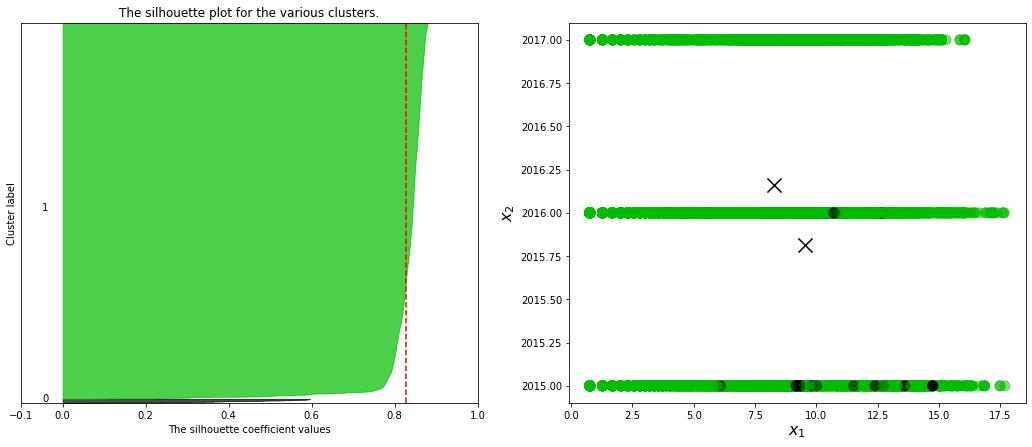

In [14]:
k = 2
kmeans = KMeans(n_clusters=k).fit(X)
plot_silhouette(X,k,kmeans.labels_,kmeans.cluster_centers_)

Se puede ver que no funciona muy bien, ya que obtenemos un inertia muy alto y casi todos los datos pertenecen al mismo grupo.

### Variable Objetivo: stays_nights
Normalizamos los datos y aplicamos TSNE para ver los datos en dos dimensiones:

In [86]:
X = data.drop(['stays_nights', 'Unnamed: 0'], axis=1).values
Y = data.stays_nights

In [87]:
columns = data.drop(['stays_nights', 'Unnamed: 0'], axis=1).columns

In [88]:
scaler = preprocessing.StandardScaler().fit(X)
Xs = scaler.transform(X)

Aplicamos TSNE para ver una representación de los datos:

In [90]:
from sklearn.manifold import TSNE

Xs = TSNE(n_components=2, random_state=0).fit_transform(Xs)

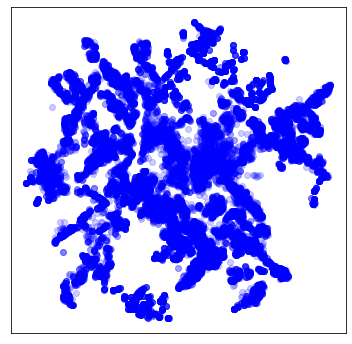

In [91]:
plt.figure(figsize=(6, 6))
plt.scatter(Xs[:, 0], X_tsne[:, 1], c = 'b', marker='o', alpha=0.2)
plt.xticks([])
plt.yticks([])
plt.show();

Se puede ver no hay grandes distancias que separen unos grupos de otros.


Aún así,vamos a ver cual es el número de cluster más óptimo para nuestros datos.

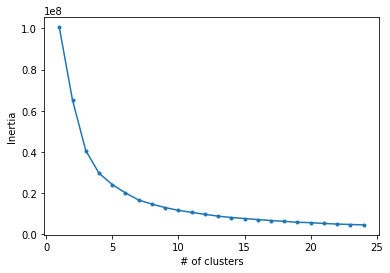

In [92]:
K = range(1,25)

inertia = []
for k in K:
    kmeans = KMeans(n_clusters=k).fit(Xs)
    inertia.append(kmeans.inertia_)
    
plt.plot(K,inertia,'.-')
plt.xlabel('# of clusters')
plt.ylabel('Inertia')
plt.show()

Aunque no queda un número muy claro, vamos a seleccionar K=10.

Vamos a ver las dimensiones de los distintos clusters para intentar encontrar alguna relación:

Cluster sizes k-means: [2703 2839 3402 3599 2516 2619 2925 2629 3241 3527]
Cluster distances k-means: [226856640.0, 210575380.0, 194574500.0, 115578720.0, 220814020.0, 232305600.0, 204170290.0, 223864460.0, 202523360.0, 108992180.0]


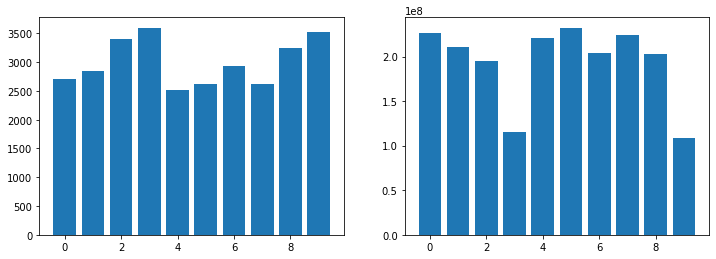

In [93]:
k = 10
kmeans = KMeans(n_clusters=k, random_state=0)
labels_km = kmeans.fit_predict(Xs)

print("Cluster sizes k-means: {}".format(np.bincount(labels_km)))

distances = []
for c in kmeans.cluster_centers_:
    d = np.sum( np.sum((Xs - c) ** 2, axis=1) ) 
    distances.append(d.round(2))
    
print("Cluster distances k-means: {}".format(distances))

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.bar(range(k),np.bincount(labels_km))

plt.subplot(122)
plt.bar(range(k),distances)
plt.show()

Podemos ver que en los clusters con más elementos, son en los que estos están más centrados.


Ahora vamos a ver los datos del cluster con datos más centrados y los datos del cluster con datos más separados:

In [94]:
def close_to_far_from_center(x,centroid, n=5):
    
    distance = np.sum((x - centroid) ** 2, axis=1)
    
    print('Close to center')
    display(pd.DataFrame(X[np.argsort(distance)[:n]], columns= columns))
    
    print('Far from center')
    display(pd.DataFrame(X[np.argsort(distance)[-n:]], columns= columns))

In [95]:
close_to_far_from_center(Xs,kmeans.cluster_centers_[9])

Close to center


,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,is_repeated_guest,previous_cancellations,...,hotel_Resort Hotel,meal_FB,meal_HB,meal_SC,meal_Undefined,deposit_type_Non Refund,deposit_type_Refundable,reserverd/assigned,customer_type_Group,customer_type_Transient-Party
0,0.0,16.865000,2015.0,31.0,1.0,2.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.0,13.879038,2015.0,43.0,19.0,2.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.0,13.183459,2015.0,43.0,19.0,2.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.0,15.975893,2015.0,37.0,7.0,2.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.0,13.863309,2015.0,43.0,19.0,2.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


Far from center


,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,is_repeated_guest,previous_cancellations,...,hotel_Resort Hotel,meal_FB,meal_HB,meal_SC,meal_Undefined,deposit_type_Non Refund,deposit_type_Refundable,reserverd/assigned,customer_type_Group,customer_type_Transient-Party
0,0.0,12.221072,2016.0,37.0,5.0,2.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
1,1.0,9.021188,2017.0,31.0,1.0,2.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
2,0.0,10.495700,2016.0,42.0,11.0,2.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
3,0.0,10.495700,2016.0,42.0,11.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
4,0.0,4.646389,2016.0,42.0,11.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0


Como podemos ver, los datos más cercanos son bastante parecidos.

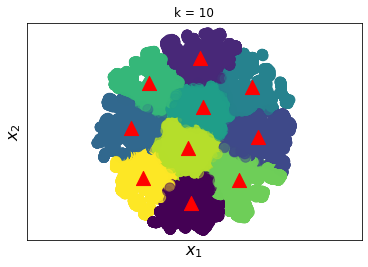

In [96]:
# build the clustering model
k = 10
kmeans = KMeans(n_clusters = k)
kmeans.fit(Xs)

# Centroids 
centroids = kmeans.cluster_centers_

# Labels
cluster_labels = kmeans.labels_

# do the plotting
plot_scatter(Xs,'k = ' + str(k), cluster_labels, centroids)
plt.show()

Vemos que son grupos que no están muy bien diferenciados unos de otros.

In [102]:
Y_predicted = kmeans.predict(Xs)
Y_predicted

array([3, 7, 8, ..., 3, 8, 1], dtype=int32)

In [103]:
Y

0        7.0
1        2.0
2        2.0
3        4.0
4        2.0
        ... 
29995    4.0
29996    1.0
29997    2.0
29998    3.0
29999    2.0
Name: stays_nights, Length: 30000, dtype: float64

In [104]:
from sklearn.metrics import mean_squared_error

rms = mean_squared_error(Y, Y_predicted, squared=False)
rms

3.8696640681072045

Vemos que tiene un RMSE alto para el rango en el que se mueve nuestra variable objetivo (es un poco mayor que la media).

In [99]:
k = 10
kmeans = KMeans(n_clusters=k).fit(Xs)
kmeans.inertia_

11711969.0

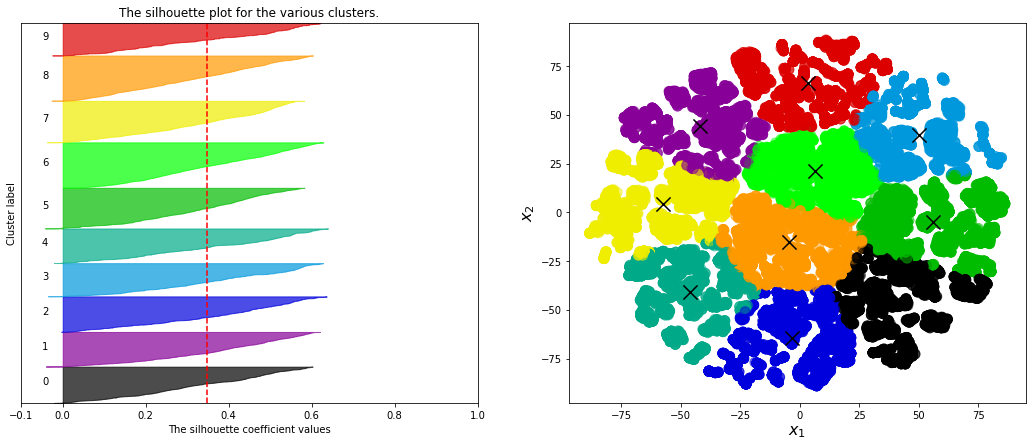

In [100]:
k = 10
kmeans = KMeans(n_clusters=k).fit(Xs)
plot_silhouette(Xs,k,kmeans.labels_,kmeans.cluster_centers_)

La conclusión es que la separación por clusters no ha sido eficiente, ya los grupos no están lo suficientemente diferenciados y el RMSE que hemos obtenido es alto.


Vamos a utilizar DB-SCAN para dividir nuestros datos en grupos:

## DB-SCAN
Vamos a probar DB-SCAN con distintos valores de eps y siempre min_samples=10

### Variable Objetivo: is_canceled

Vamos a normalizar los datos y aplicamos DB-SCAN tratando de encontrar dos clusters, y entonces ver cuantos elementos hay en cada uno:

In [6]:
X = data.drop(['is_canceled', 'Unnamed: 0'], axis=1).values
Y = data.is_canceled

In [7]:
from sklearn import preprocessing 

scaler = preprocessing.StandardScaler().fit(X)
Xs = scaler.transform(X)

In [ ]:
from sklearn.cluster import DBSCAN

for eps in [7, 8, 9]:
    print("\neps={}".format(eps))
    dbscan = DBSCAN(eps=eps, min_samples=10)
    labels = dbscan.fit_predict(Xs)
    print("Number of clusters: {}".format(len(np.unique(labels))))
    print("Cluster sizes: {}".format(np.bincount(labels + 1)))


eps=7


### Variable Objetivo: stays_nights
Normalizamos los datos y aplicamos DB-SCAN:

In [8]:
X = data.drop(['stays_nights', 'Unnamed: 0'], axis=1).values
Y = data.stays_nights

In [9]:
columns = data.drop(['stays_nights', 'Unnamed: 0'], axis=1).columns

In [10]:
scaler = preprocessing.StandardScaler().fit(X)
Xs = scaler.transform(X)

In [ ]:
from sklearn.cluster import DBSCAN

for eps in [1, 3, 5, 6, 7, 8, 9]:
    print("\neps={}".format(eps))
    dbscan = DBSCAN(eps=eps, min_samples=10)
    labels = dbscan.fit_predict(Xs)
    print("Number of clusters: {}".format(len(np.unique(labels))))
    print("Cluster sizes: {}".format(np.bincount(labels + 1)))


eps=1
Number of clusters: 188
Cluster sizes: [14161    85    41    42    21   244   128   350   100    88    14   181
   119   131    91    50   109    61    48    59    13    51    64    31
    17    19    62    11    18    22    12    11    19    25    26    10
    12   845   724   605   150   346   178   251   216    19    67   271
   105    44    15    51   102   241    62    11   739    67    16   163
    50    58    56   179    64    16    13    10   115    41    13    12
    11   140    77    11    11    10    54   138    12    13    29    14
    10    18    23     8    32    82    63    20    32    19    23    23
    15    11    64    21    54    18    14    10    17    24    11    11
    11    15    10    39    14    13    27    17    18    15    19    14
    11    15    11     9   461   488   542   174   223   197   242   171
    47   235   720   189   184    37    70   202   109   187    96    90
    97    89    69    18    26    81    52    93    58    34    38    44
    6

## Arboles de decision

Un árbol de decisión es una estructura arbórea similar a un diagrama de flujo en la que un nodo interno representa una característica (o atributo), la rama representa una regla de decisión y cada nodo de hoja representa el resultado. El nodo superior de un árbol de decisión se conoce como nodo raíz. Aprende a dividir en función del valor del atributo. La partición del árbol se denomina partición recursiva. Esta estructura similar a un diagrama de flujo le ayuda en la toma de decisiones. Se visualiza como un diagrama de flujo que imita fácilmente el pensamiento a nivel humano. Por eso los árboles de decisión son fáciles de entender e interpretar.

El árbol de decisión es un algoritmo de caja blanca de ML. Comparte la lógica interna de la toma de decisiones, que no está disponible en el tipo de algoritmos de caja negra como la red neuronal. Su tiempo de entrenamiento es más rápido en comparación con el algoritmo de la red neuronal. La complejidad temporal de los árboles de decisión es una función del número de registros y del número de atributos en los datos dados. El árbol de decisión es un método no paramétrico, que no depende de supuestos de distribución de probabilidad. Los árboles de decisión pueden manejar datos de alta dimensión con buena precisión.


In [8]:
data_tree = pd.read_csv('simple-hotels.csv',delimiter=",")

In [9]:
drop_elements=["arrival_date_week_number","arrival_date_year","arrival_date_day_of_month","agent","company","reservation_status","reservation_status_date","arrival_date_month","country"]
data_tree = data_tree.drop(drop_elements,axis=1)

In [11]:
data_tree.groupby("is_canceled").size()

is_canceled
0    6249
1    3751
dtype: int64

In [12]:
data_tree['hotel_encoded'] = data_tree['hotel'].map({'City Hotel': 0, 'Resort Hotel': 1, '': 3}).astype(int)
data_tree['meal_encoded'] = data_tree['meal'].map({'BB': 0, 'SC': 1, 'HB': 3, 'FB': 4, 'Undefined': 5, '': 5}).astype(int)
data_tree['market_seg_encoded'] = data_tree['market_segment'].map({'Online TA': 0, 'Direct': 1, 'Groups': 3, 'Offline TA/TO': 4, 'Corporate': 5, 'Aviation': 6, 'Complementary': 7, '':0}).astype(int)
data_tree['dist_chnl_encoded'] = data_tree['distribution_channel'].map({'TA/TO': 0, 'Direct': 1, 'Corporate': 3, 'GDS': 4, '': 5}).astype(int)
data_tree['res_room_type_encoded'] = data_tree['reserved_room_type'].map({'D': 0, 'A': 1, 'E': 3, 'F': 4, 'G': 5, 'C': 6, 'H': 7,'B': 8, 'P': 9, 'L': 10, '':11}).astype(int)
data_tree['asig_room_type_encoded'] = data_tree['assigned_room_type'].map({'D': 0, 'A': 1, 'E': 3, 'F': 4, 'G': 5, 'C': 6, 'H': 7,'B': 8, 'P': 9, 'K': 10, '':11, 'I': 12}).astype(int)
data_tree['depo_type_encoded'] = data_tree['deposit_type'].map({'No Deposit': 0, 'Non Refund': 1, 'Refundable': 3, '': 4}).astype(int)
data_tree['cust_type_encoded'] = data_tree['customer_type'].map({'Transient': 0, 'Transient-Party': 1, 'Contract': 3, 'Group': 4, '': 5}).astype(int)

In [13]:
drop_elements=["hotel","meal","market_segment","distribution_channel","reserved_room_type","assigned_room_type","deposit_type","customer_type"]
data_tree_encoded = data_tree.drop(drop_elements,axis=1)

In [14]:
cv = KFold(n_splits=10) # Numero deseado de "folds" que haremos
accuracies = list()
max_attributes = len(list(data_tree_encoded))
depth_range = range(1, max_attributes + 1)

for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='entropy',
                                             min_samples_split=50,
                                             min_samples_leaf=25,
                                             max_depth = depth,
                                             class_weight={1:1.6})
    for train_fold, valid_fold in cv.split(data_tree_encoded):
        f_train = data_tree_encoded.loc[train_fold] 
        f_valid = data_tree_encoded.loc[valid_fold] 
 
        model = tree_model.fit(X = f_train.drop(['is_canceled'], axis=1), 
                               y = f_train["is_canceled"]) 
        valid_acc = model.score(X = f_valid.drop(['is_canceled'], axis=1), 
                                y = f_valid["is_canceled"]) # calculamos la precision con el segmento de validacion
        fold_accuracy.append(valid_acc)
 
    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    
# Mostramos los resultados obtenidos
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1            0.7430
         2            0.7430
         3            0.7430
         4            0.7103
         5            0.8013
         6            0.8076
         7            0.8070
         8            0.8067
         9            0.7971
        10            0.7939
        11            0.7926
        12            0.7882
        13            0.7872
        14            0.7881
        15            0.7834
        16            0.7791
        17            0.7806
        18            0.7812
        19            0.7798
        20            0.7804
        21            0.7798
        22            0.7798
        23            0.7795


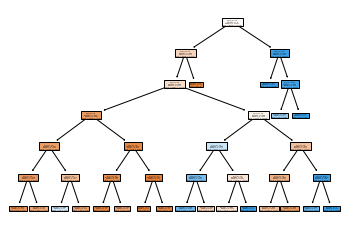

In [16]:
y_train = data_tree_encoded['is_canceled']
x_train = data_tree_encoded.drop(['is_canceled'], axis=1).values 
 
# Crear Arbol de decision con profundidad = 6
decision_tree = tree.DecisionTreeClassifier(criterion='entropy',
                                            min_samples_split=50,
                                            min_samples_leaf=25,
                                            max_depth = 6,
                                            class_weight={1:1.6})
decision_tree.fit(x_train, y_train)
r = export_text(decision_tree, feature_names=list(data_tree_encoded.drop(['is_canceled'], axis=1)))
tree.plot_tree(decision_tree, filled=True)
plt.show()

## Random Forest

In [57]:
cv = KFold(n_splits=8)
for train_fold, valid_fold in cv.split(data_tree_encoded):
        f_train = data_tree_encoded.loc[train_fold] 
        f_valid = data_tree_encoded.loc[valid_fold] 

x_train = f_train.drop(['is_canceled'], axis=1)
y_train = f_train["is_canceled"]
x_test = f_valid.drop(['is_canceled'], axis = 1)
y_test = f_valid['is_canceled']

#x_train, y_train = make_classification(n_samples=100, n_features=22,
                           #n_informative=2, n_redundant=0,
                            #random_state=0, shuffle=False)
clf = RandomForestClassifier(max_depth=6, random_state=0, oob_score=True, class_weight={1:1.6})
clf.fit(x_train, y_train)



RandomForestClassifier(class_weight={1: 1.6}, max_depth=6, oob_score=True,
                       random_state=0)

In [58]:
import sklearn.metrics
predictions = clf.predict(x_test)
sklearn.metrics.confusion_matrix(y_test,predictions)

array([[717,  70],
       [158, 305]], dtype=int64)

In [59]:
sklearn.metrics.accuracy_score(y_test, predictions)

0.8176

In [63]:
model = ExtraTreesClassifier()
model.fit(x_train,y_train)
print(model.feature_importances_)

[0.18888869 0.04716868 0.07538019 0.02503268 0.0122707  0.00213642
 0.00539756 0.03172106 0.00300665 0.0293792  0.00460701 0.13715629
 0.02710233 0.07283916 0.01797376 0.02482699 0.0460312  0.01835601
 0.02388568 0.03441833 0.13758201 0.03483939]


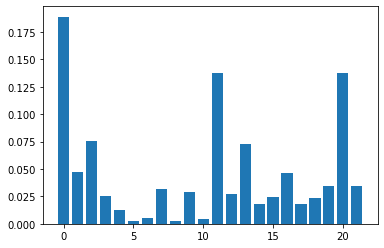

In [64]:
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

In [65]:
x_train.columns

Index(['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights',
       'adults', 'children', 'babies', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'booking_changes', 'days_in_waiting_list', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'hotel_encoded', 'meal_encoded', 'market_seg_encoded',
       'dist_chnl_encoded', 'res_room_type_encoded', 'asig_room_type_encoded',
       'depo_type_encoded', 'cust_type_encoded'],
      dtype='object')